<a href="https://colab.research.google.com/github/moo-337/moo/blob/master/docs/get_started_euro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
print("TF version =", tf.__version__)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot

from tensorflow.keras import initializers
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import scipy.stats as stats

TF version = 2.9.2


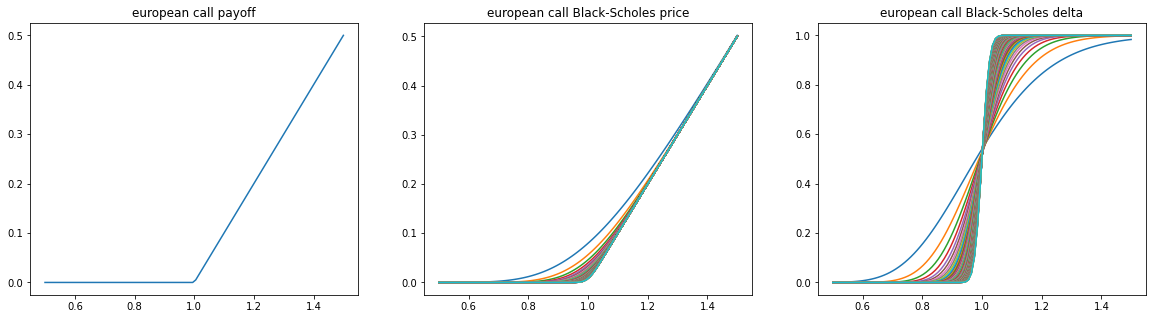

In [2]:
global strike, sigma

N = 100 # of timestep
S0 = 1 # initial underlying price
T = 1 # time to maturity
strike = 1.
sigma = 0.2

# european call option payoff function 
def payoff_f(x):
    return 0.5*(K.abs(x-strike)+x-strike)

def BS_closedform(S, T):
    return S*stats.norm.cdf((np.log(S/strike)+(0.5*sigma**2)*T)/(sigma*np.sqrt(T)), 0, 1) - strike*stats.norm.cdf((np.log(S/strike)-(0.5*sigma**2)*T)/(sigma*np.sqrt(T)), 0, 1)

def BS_delta(S, T):
    return stats.norm.cdf((np.log(S/strike)+(0.5*sigma**2)*T)/(sigma*np.sqrt(T)), 0, 1)

x = np.linspace(0.5, 1.5, 100).reshape((-1,1))

fig0, ax0 = plt.subplots(1, 3, squeeze=False)
fig0.set_size_inches(20, 5)

ax0[0, 0].set_title("european call payoff")
ax0[0, 1].set_title("european call Black-Scholes price")
ax0[0, 2].set_title("european call Black-Scholes delta")

ax0[0, 0].plot(x, payoff_f(x))

for i in range(N):
    ax0[0, 1].plot(x, BS_closedform(x, T/(i+1)))
    ax0[0, 2].plot(x, BS_delta(x, T/(i+1)))

In [3]:
# Neural Network architecture for hedging a portfolio of derivatives

u = 1 # dimension of underlying assets, e.g. 1 
m = 1 # dimension of derivative prices, e.g. 1
d = 3 # number of hidden layers, e.g. 3
n = 32 # units in hidden layers, e.g. 32

layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,1),
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        else:
            nodes = m # output layer of each timestep
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]

price = Input(shape=(u,))
hedge = Input(shape=(u,))
hedgeeval = Input(shape=(u,))
premium = Input(shape=(m,))

inputs = [price]+[hedge]+[hedgeeval]+[premium]
outputhelper = []

premium = Dense(m, activation='linear', trainable=True,
                kernel_initializer=initializers.RandomNormal(0,0.1),
                          bias_initializer=initializers.RandomNormal(0,0.1))(premium)

for j in range(N):
    strategy = price
    strategyeval = hedgeeval
    for k in range(d):
        strategy = layers[k+(j)*d](strategy) # layer for optimal hedge training. this layer used for training only
        strategyeval = layers[k+(j)*d](strategyeval) # layer for hedge value prediction. this layer used for predict only
    
    incr = Input(shape=(u,))
    logprice = Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew = Lambda(lambda x : K.exp(x))(logprice)
    priceincr = Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    hedge = Add()([hedge, hedgenew])
    inputs = inputs + [incr]
    outputhelper = outputhelper + [strategyeval]
    price = pricenew

In [4]:
payoff = Lambda(payoff_f)(price)
outputs = Subtract()([payoff, hedge])
outputs = Subtract()([outputs, premium])
outputs = [outputs] + outputhelper + [premium]
outputs = Concatenate()(outputs)

model_hedge_strat = Model(inputs=inputs, outputs=outputs)

In [5]:
gamma = 1.0
grid = [(i/N)**gamma*T for i in range(N+1)]

Ktrain = 10**5
initialprice = S0
priceBS = BS_closedform(initialprice, T)
print(priceBS)

xtrain = ([initialprice*np.ones((Ktrain, u))] + 
          [np.zeros((Ktrain, m))] +
          [np.ones((Ktrain, m))] +
          [priceBS*np.ones((Ktrain, m))] + 
          [np.random.normal(-(sigma)**2/2*(grid[i+1]-grid[i]), sigma*np.sqrt(grid[i+1]-grid[i]), (Ktrain, u)) for i in range(N)])

ytrain = np.zeros((Ktrain, 1+N))
# ytrain[:, 0] += 0.05

0.07965567455405798


In [6]:
def loss_mse(y_true, y_pred):
    return K.mean(K.square(y_pred[:, 0]-y_true[:,0]))

model_hedge_strat.compile(optimizer='adam', loss=loss_mse)

for i in range(50):
    model_hedge_strat.fit(x=xtrain, y=ytrain, epochs=1, verbose=True, batch_size=1000)

100/100 [==============================] - 6s 63ms/step - loss: 6.3136e-05


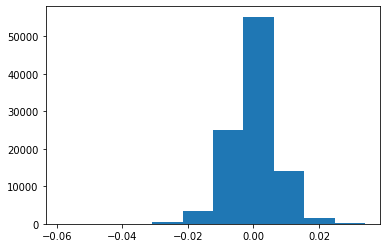

number of paths :  100000
BS delta hedging result mean :  3.9708391960346504e-05  std :  0.006899042800477535
BS delta hedging result max value :  0.03410077058201171  min value :  -0.0588048602768832


In [7]:
logincrements = xtrain[4:]
hedge_bs = np.zeros(Ktrain)
price_train = S0*np.ones((Ktrain, N+1))

for k in range(N):
    helper = logincrements[k][:,]
    helper = helper.transpose()
    delta = BS_delta(price_train[:,k], T-grid[k])
    price_train[:, k+1] = price_train[:, k]*np.exp(helper)
    hedge_bs = hedge_bs + delta * (price_train[:, k+1] - price_train[:, k])

hedge_bs = hedge_bs - payoff_f(price_train[:, -1]) + priceBS

plt.hist(hedge_bs)
plt.show()
print("number of paths : ", Ktrain)
print("BS delta hedging result mean : ", np.mean(hedge_bs), " std : ", np.std(hedge_bs))
print("BS delta hedging result max value : ", np.max(hedge_bs), " min value : ", np.min(hedge_bs))

In [8]:
Ktest=10000

testpath=[]

for i in range(N):
    testpath.append(np.random.normal(-(sigma)**2/2*(grid[i+1]-grid[i]), sigma*np.sqrt(grid[i+1]-grid[i]), (Ktest, u)))

logincrements = testpath
hedge_bs = np.zeros((Ktest, N+1))
price_test = S0*np.ones((Ktest, N+1))
delta_bs = np.zeros((Ktest, N+1))

for k in range(N):
    helper = logincrements[k].reshape((-1,))
    delta_bs[:, k] += BS_delta(price_test[:,k], T-grid[k])
    price_test[:, k+1] = price_test[:, k]*np.exp(helper)
    hedge_bs[:, k+1] = hedge_bs[:, k] + delta_bs[:, k] * (price_test[:, k+1] - price_test[:, k])

hedge_bs[:, -1] = hedge_bs[:, -2] - payoff_f(price_test[:, -1]) + priceBS

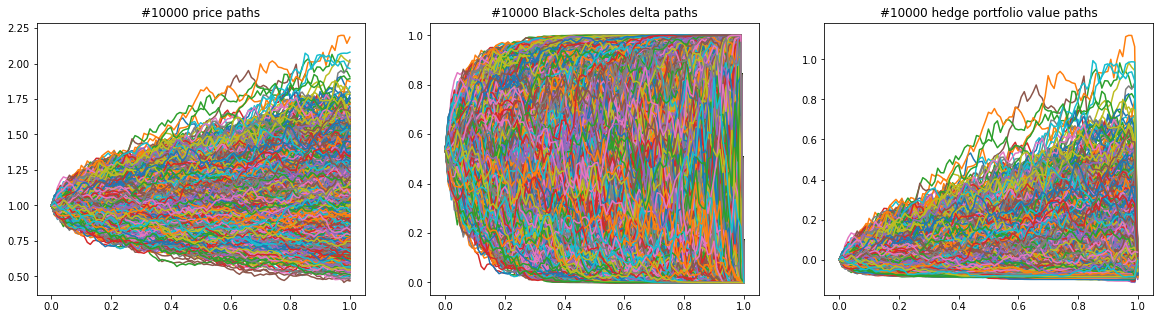

In [9]:
fig1, ax1 = plt.subplots(1, 3, squeeze=False)
fig1.set_size_inches(20, 5)

ax1[0, 0].set_title("#{} price paths".format(Ktest))
ax1[0, 1].set_title("#{} Black-Scholes delta paths".format(Ktest))
ax1[0, 2].set_title("#{} hedge portfolio value paths".format(Ktest))

for i in range(Ktest):
    ax1[0, 0].plot(grid, price_test[i])
    ax1[0, 1].plot(grid, delta_bs[i])
    ax1[0, 2].plot(grid, hedge_bs[i])

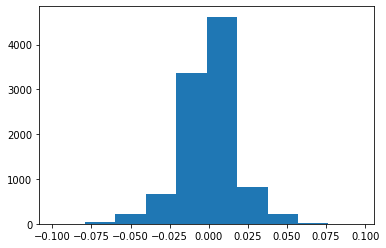

number of paths :  10000
BS delta hedging result mean :  -0.00018747395998093596  std :  0.017267743574860103
BS delta hedging result max value :  0.09604005107587915  min value :  -0.09862731246010734


In [10]:
plt.hist(hedge_bs[:,-1])
plt.show()

print("number of paths : ", Ktest)
print("BS delta hedging result mean : ", np.mean(hedge_bs[:, -1]), " std : ", np.std(hedge_bs[:, -1]))
print("BS delta hedging result max value : ", np.max(hedge_bs[:, -1]), " min value : ", np.min(hedge_bs[:, -1]))

313/313 [==============================] - 15s 32ms/step


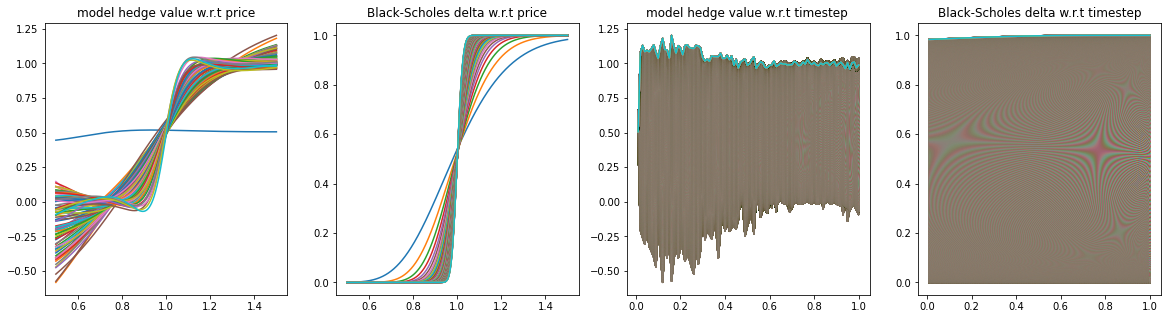

In [11]:
xtest = ([initialprice*np.ones((Ktest, u))] + 
         [np.zeros((Ktest, m))] + 
         [np.linspace(0.5, 1.5, Ktest)] +
         [priceBS*np.ones((Ktest, m))] + 
         [testpath[i] for i in range(N)])

y = model_hedge_strat.predict(xtest)

model_hedge = y[:, 0]
model_premium = y[:, -1]

fig2, ax2 = plt.subplots(1, 4, squeeze=False)
fig2.set_size_inches(20, 5)

ax2[0, 0].set_title("model hedge value w.r.t price")
ax2[0, 1].set_title("Black-Scholes delta w.r.t price")
ax2[0, 2].set_title("model hedge value w.r.t timestep ")
ax2[0, 3].set_title("Black-Scholes delta w.r.t timestep")

s = np.linspace(0.5, 1.5, Ktest)

for i in range(N):
    ax2[0, 0].plot(s, y[:, i+1])
    BSdelta = BS_delta(s, T/(i+1))
    ax2[0, 1].plot(s, BSdelta)

for k in range(Ktest):
    ax2[0, 2].plot(grid[1:], y[k, 1:-1])
    BSdelta = BS_delta(s[k], T - np.array(grid[:-1]))
    ax2[0, 3].plot(grid[1:], BSdelta)

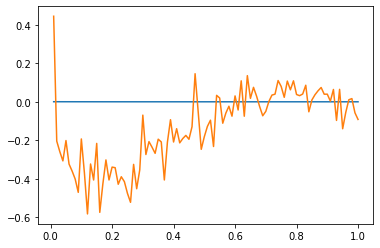

In [12]:
idx = 0
BSdelta = BS_delta(s[idx], T - np.array(grid[:-1]))
plt.plot(grid[1:], BSdelta, grid[1:], y[idx, 1:-1])

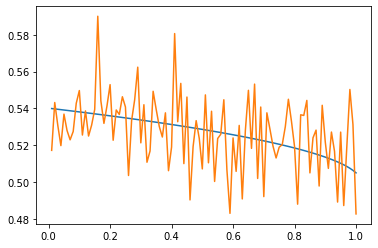

In [13]:
idx = int(Ktest/2)
BSdelta = BS_delta(s[idx], T - np.array(grid[:-1]))
plt.plot(grid[1:], BSdelta, grid[1:], y[idx, 1:-1])

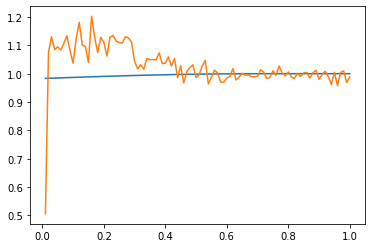

In [14]:
idx = -1
BSdelta = BS_delta(s[idx], T - np.array(grid[:-1]))
plt.plot(grid[1:], BSdelta, grid[1:], y[idx, 1:-1])

In [15]:
def model_delta(model, s):
    n = len(s)
    x = ([initialprice*np.ones((n, u))] + 
         [np.zeros((n, m))] + 
         [s] +
         [priceBS*np.ones((n, m))] + 
        #  [testpath[i] for i in range(N)])
         [np.ones((n, u)) for i in range(N)])
    out = model.predict(x)
    return out[:, 1:-1]

hedge_model = np.zeros((Ktest, N+1))
price_test = S0*np.ones((Ktest, N+1))
delta_model = np.zeros((Ktest, N+1))

for k in range(N):
    helper = logincrements[k].reshape((-1,))
    modelta =  model_delta(model_hedge_strat, price_test[:, k])
    delta_model[:, k] += modelta[:, k]
    price_test[:, k+1] = price_test[:, k]*np.exp(helper)
    hedge_model[:, k+1] = hedge_model[:, k] + delta_model[:, k] * (price_test[:, k+1] - price_test[:, k])

hedge_model[:, -1] = hedge_model[:, -2] - payoff_f(price_test[:, -1]) + priceBS

313/313 [==============================] - 10s 32ms/step


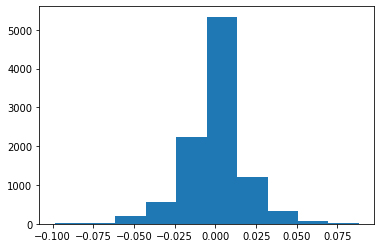

number of paths :  10000
Neural Network model delta hedging result mean :  -0.00018697900560784756  std :  0.017760474849232915
Neural Network model delta hedging result max value :  0.08816359120787948  min value :  -0.09890093989588464


In [16]:
plt.hist(hedge_model[:, -1])
plt.show()

print("number of paths : ", Ktest)
print("Neural Network model delta hedging result mean : ", np.mean(hedge_model[:, -1]), " std : ", np.std(hedge_model[:, -1]))
print("Neural Network model delta hedging result max value : ", np.max(hedge_model[:, -1]), " min value : ", np.min(hedge_model[:, -1]))

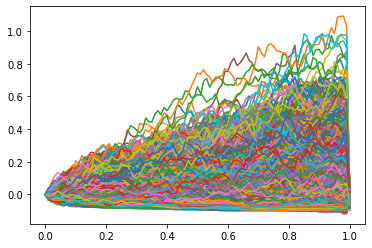

In [17]:
for i in range(Ktest):
    plt.plot(grid, hedge_model[i])

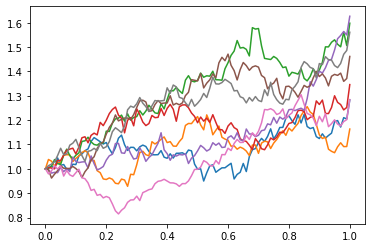

In [18]:
for i in range(Ktest):
    if hedge_model[i][-1] < np.min(hedge_model[:, -1]) + np.std(hedge_model[:, -1]):
        plt.plot(grid[:], price_test[i])

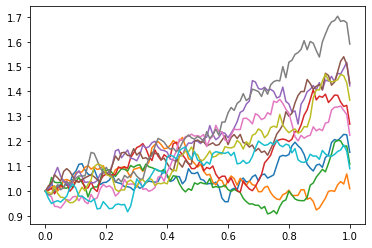

In [19]:
for i in range(Ktest):
    if hedge_model[i][-1] > np.max(hedge_model[:, -1]) - np.std(hedge_model[:, -1]):
        plt.plot(grid[:], price_test[i])